In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_colwidth', 300)

# Data Understanding

In [2]:
# load datasets
schema = pd.read_csv('survey_results_schema.csv')
schema2 = pd.read_csv('schema.csv', sep=';')
df = pd.read_csv('survey_results_public.csv')

In [3]:
df.shape

(88883, 85)

In [4]:
df.describe()

,Respondent,CompTotal,ConvertedComp,WorkWeekHrs,CodeRevHrs,Age
count,88883.000000,5.594500e+04,5.582300e+04,64503.000000,49790.000000,79210.000000
mean,44442.000000,5.519014e+11,1.271107e+05,42.127197,5.084308,30.336699
std,25658.456325,7.331926e+13,2.841523e+05,37.287610,5.513931,9.178390
min,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000
25%,22221.500000,2.000000e+04,2.577750e+04,40.000000,2.000000,24.000000
50%,44442.000000,6.200000e+04,5.728700e+04,40.000000,4.000000,29.000000
75%,66662.500000,1.200000e+05,1.000000e+05,44.750000,6.000000,35.000000
max,88883.000000,1.000000e+16,2.000000e+06,4850.000000,99.000000,99.000000


In [5]:
schema.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,"Which of the following options best describes you today? Here, by ""developer"" we mean ""someone who writes code."""
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open source software (OSS)?


We have prepared another schema data that we'll be a little bit more handy (when addressing the 3rd question).

In [207]:
schema2 = pd.read_csv('schema.csv', sep=';')
schema2.head(20)

,Column,Section,QuestionText
0,Respondent,Basic Info,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,Basic Info,"Which of the following options best describes you today? Here, by 'developer' we mean 'someone who writes code.'"
2,Hobbyist,Basic Info,Do you code as a hobby?
3,OpenSourcer,Basic Info,How often do you contribute to open source?
4,OpenSource,Basic Info,How do you feel about the quality of open source software (OSS)?
5,Employment,Basic Info,Which of the following best describes your current employment status?
6,Country,Basic Info,In which country do you currently reside?
7,Student,"Education, Work, Career","Are you currently enrolled in a formal, degree-granting college or university program?"
8,EdLevel,"Education, Work, Career",Which of the following best describes the highest level of formal education that youâ€™ve completed?
9,UndergradMajor,"Education, Work, Career",What was your main or most important field of study?


## Basic visualization (numeric data)

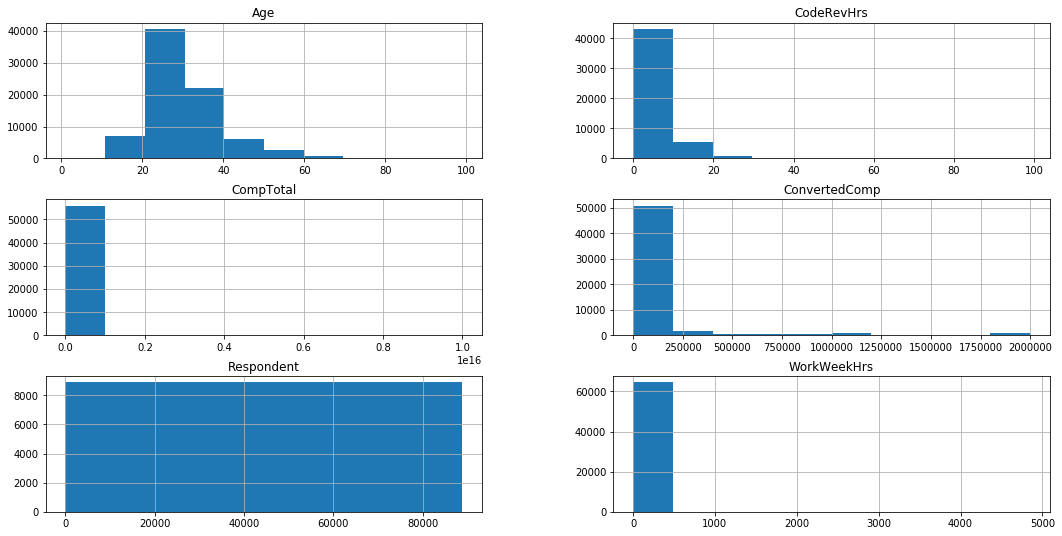

In [45]:
df.hist(figsize=(18,9));

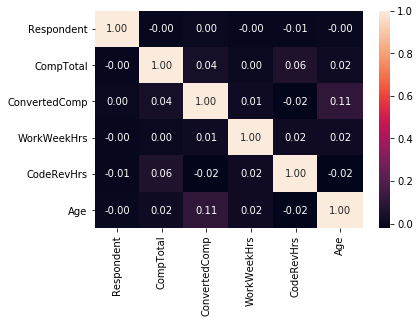

In [46]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

We will address 3 different topics and in each one we'll expose one question of interest. **The first topic** is purely statistic, our interest will be to get to know about the most popular technologies. In **the second topic** we'll be digging into the relation between the formal education level and the non-formal degrees of education trying to find out if there is any tangible difference between the high and low education level in terms of the non-formal education. In **the last topic** we'll try to predict the salary using the limited number of selected variables by the standard regression model that was used in the Udacity lesson.  

# QUESTION 1

What are the most popular programming languages, databases, platforms, web frameworks, and other frameworks among the developers? 

We'll make a simple statistics on each of the 5 variables (**LanguageWorkedWith**, **DatabaseWorkedWith**, **PlatformWorkedWith**, **WebFrameWorkedWith**, **MiscTechWorkedWith**). We'll treat each feature independently since we just want to get to the list of ordered values, one list per each feature. 

The specific of this statistics is that the values of all variables are given as concatenated strings, so we have to parse them and distribute parsed values over various columns. Note that we'll aggregate the last 20% of the distribution into the 'Others' category.

Due to the nature of our interest we'll isolate every feature from the other which simplifies a lot how we treat null values and the concatenated values. As we only need to count different values, null values can be safely removed. Similarily, the concatenated values will be split into the list of values and finally all lists will be merged into a single list.  

## Common Functions

In [47]:
def parse_values(s, threshold):
    '''
    Split concatenated values into separate values and calculate the basic statistic 
    (count/percentage). 
    
    INPUT
    s - pandas series
    threshold - threshold in percentage of the rest of the lowest values aggregated 
    into a single category

    OUTPUT
    pandas dataframe with count and percentage value for each category
    '''    
    data = s.str.split(';')
    flatlist = []
    for item in data:
        for item2 in item:
            flatlist.append(item2)
    
    df2 = pd.DataFrame({ 'count': pd.Series(data=flatlist).value_counts()})
    
    # Remove 'Other(s)' column
    othersRow = 'Other(s):'
    if othersRow in df2.index:
        df2.drop(othersRow, axis=0, inplace=True)
    
    # Aggregate less frequent values into a single value (falling below a given threshold)
    df3 = pd.DataFrame({ 'count' : []})
    others = 0  
    total = df2['count'].sum()
    
    for row in df2.sort_values(by='count').iterrows():
        count = row[1][0]
  
        if (others + count)/total * 100 < threshold:
            others += count
            continue

        new_row = pd.DataFrame({ 'count': [row[1][0]], 'percentage': row[1][0]/total*100 },
                               index=[row[0]])
        df3 = df3.append(new_row)              
        
    if others > 0:  
        return pd.concat([df3.sort_values(by='count', ascending=False), 
                          pd.DataFrame({ 'count': others, 'percentage': others/total*100 }, 
                                       index=['others'])])
    else:
        return df3.sort_values(by='count', ascending=False)
    
    
# Prepare statistic data
def stat(df, col, threshold):
    '''
    INPUT
    df - pandas dataframe
    col - name of the columns to be parsed and statistically processed
    threshold - threshold in percentage of the rest of the lowest values aggregated 
    into a single category
    
    OUTPUT
    plot of the parsed values distribution 
    '''        
    s = df[col]
    # remove null rows
    s = s.dropna()
    # parse values
    df2 = parse_values(s, threshold)
    # plot
    df2['percentage'].plot.bar()

In [48]:
# Set the threshold for the 'others' values:
threshold = 20

## Statistic

### Feature 1: LanguageWorkedWith

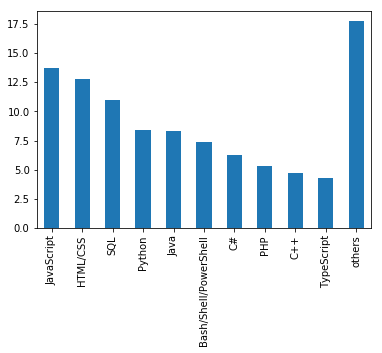

In [49]:
stat(df, 'LanguageWorkedWith', threshold)

### Feature 2: DatabaseWorkedWith

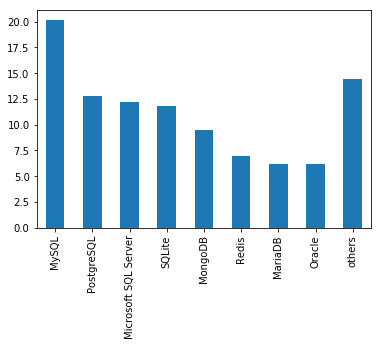

In [13]:
stat(df, 'DatabaseWorkedWith', threshold)

### Feature 3: PlatformWorkedWith

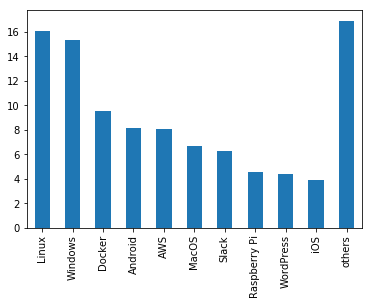

In [14]:
stat(df, 'PlatformWorkedWith', threshold)

### Feature 4: WebFrameWorkedWith

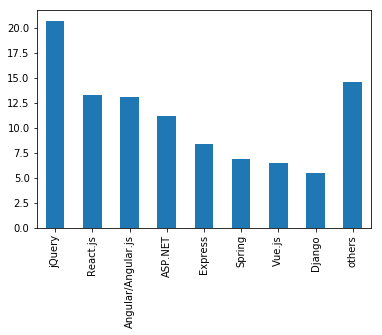

In [15]:
stat(df, 'WebFrameWorkedWith', threshold)

### Feature 5: MiscTechWorkedWith

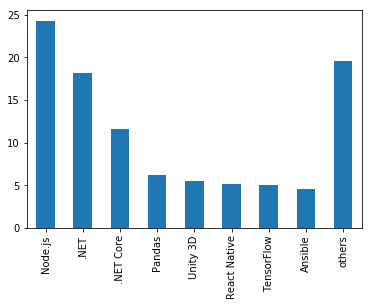

In [50]:
stat(df, 'MiscTechWorkedWith', threshold)

## Conclusion

Top 3 results per each feature are:
- **languages:** JavaScript, HTML/CSS, SQL
- **databases:** MySQL, PostgreSQL, Microsoft SQL Server
- **platforms:** Linux, Windows, Docker
- **web frameworks:** jQuery, React.js, Angular/Angular.js
- **other technologies:** Node.js, .NET, .NET Core

The web programming is prevalent. The first two languages (JavaScript and HTML/CSS) confirm this. The open-source databases like MySQL and PostgreSQL are the most frequently used among the programmers. Linux and Windows are the most popular platforms. The javascript libraries - jQuery, React and Angular - dominate the web programming. Microsoft technologies ASP.NET, .NET (Core) and SQL Server are still among the top used technologies.  

# QUESTION 2

Is there any strong correlation between the education level and non-degree education? Is there a notable difference between the low education and high education  in relation to the non-formal education?

We'll be focusing on 2 categorical variables only:
- **EdLevel** (formal education)
- **EduOther** (non-degree education)

## Common Functions

In [51]:
def get_edlevel(value):
    '''
    Convert the education level into 2-category data: 1-'high' or 0-'low'. 
    
    INPUT
    value - category to covert
    
    OUTPUT
    either 1 ('high') or 0 ('low')
    '''          
    if value in ['Master’s degree (MA, MS, M.Eng., MBA, etc.)', 
                 'Other doctoral degree (Ph.D, Ed.D., etc.)', 
                 'Professional degree (JD, MD, etc.)']:
        return 1
    else:
        return 0

In [52]:
# Variable selection
dft = df[['EdLevel', 'EduOther']].copy()
dft.head()

,EdLevel,EduOther
0,Primary/elementary school,"Taught yourself a new language, framework, or tool without taking a formal course"
1,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",Taken an online course in programming or software development (e.g. a MOOC)
2,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taught yourself a new language, framework, or tool without taking a formal course"
3,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taken an online course in programming or software development (e.g. a MOOC);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course"
4,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taken an online course in programming or software development (e.g. a MOOC);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course;Contributed to open source software"


## Missing Values

In [53]:
# Let's check the percentage of the missing values in the both columns
(dft['EdLevel'].isnull() | dft['EduOther'].isnull()).sum()/len(df) * 100

7.2252286713994804

Since the percentage of missing values is not very high, we'll just remove the rows with the missing values.

In [54]:
print(dft.shape)
dft.dropna(axis=0, inplace=True)
print(dft.shape)

(88883, 2)
(82461, 2)


In [55]:
# double check null values
(dft['EdLevel'].isnull() | dft['EduOther'].isnull()).sum()/len(df) * 100

0.0

## Encoding

In [56]:
# Convert EdLevel into binary values
dft["EduHigh"] = dft["EdLevel"].apply(get_edlevel)

In [57]:
# Split EduOther column and add the list result as a new column
dft['EduOtherList'] = dft['EduOther'].str.split(';')

In [58]:
dft.head(10)

,EdLevel,EduOther,EduHigh,EduOtherList
0,Primary/elementary school,"Taught yourself a new language, framework, or tool without taking a formal course",0,"[Taught yourself a new language, framework, or tool without taking a formal course]"
1,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",Taken an online course in programming or software development (e.g. a MOOC),0,[Taken an online course in programming or software development (e.g. a MOOC)]
2,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taught yourself a new language, framework, or tool without taking a formal course",0,"[Taught yourself a new language, framework, or tool without taking a formal course]"
3,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taken an online course in programming or software development (e.g. a MOOC);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course",0,"[Taken an online course in programming or software development (e.g. a MOOC), Received on-the-job training in software development, Taught yourself a new language, framework, or tool without taking a formal course]"
4,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taken an online course in programming or software development (e.g. a MOOC);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course;Contributed to open source software",0,"[Taken an online course in programming or software development (e.g. a MOOC), Received on-the-job training in software development, Taught yourself a new language, framework, or tool without taking a formal course, Contributed to open source software]"
5,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taken an online course in programming or software development (e.g. a MOOC);Received on-the-job training in software development;Taught yourself a new language, framework, or tool without taking a formal course",0,"[Taken an online course in programming or software development (e.g. a MOOC), Received on-the-job training in software development, Taught yourself a new language, framework, or tool without taking a formal course]"
6,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taught yourself a new language, framework, or tool without taking a formal course",0,"[Taught yourself a new language, framework, or tool without taking a formal course]"
7,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Taught yourself a new language, framework, or tool without taking a formal course;Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder);Contributed to open source software",0,"[Taught yourself a new language, framework, or tool without taking a formal course, Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder), Contributed to open source software]"
8,Some college/university study without earning a degree,Taken an online course in programming or software development (e.g. a MOOC);Participated in a full-time developer training program or bootcamp;Taken a part-time in-person course in programming or software development;Received on-the-job training in software development;Taught yourself a new lang...,0,"[Taken an online course in programming or software development (e.g. a MOOC), Participated in a full-time developer training program or bootcamp, Taken a part-time in-person course in programming or software development, Received on-the-job training in software development, Taught yourself a new..."
10,Primary/elementary school,Contributed to open source software,0,[Contributed to open source software]


In [59]:
# we'll use outer variables key & key_alt for - the lattest is used in a special scenario
# that there are 2 possible input values for a single output value
key = ''
key_alt = ''


def get_binval(val):
    '''
    Return the binary value for every EduOther value. 
    
    INPUT
    val - category
    
    OUTPUT
    1 or 2
    '''            
    if key in val:
        return 1
    elif key_alt in val:
        return 1
    else:
        return 0
    

key = 'Taken an online course in programming or software development (e.g. a MOOC)'
dft['online_course'] = dft['EduOtherList'].apply(get_binval)

key = 'Participated in a fulltime developer training program or bootcamp'
key_alt = 'Participated in a full-time developer training program or bootcamp'
dft['bootcamp'] = dft['EduOtherList'].apply(get_binval)
key_alt = ''

key = 'Taken a part-time in-person course in programming or software development'
dft['in_person_course'] = dft['EduOtherList'].apply(get_binval)

key = 'Received on-the-job training in software development'
dft['on_the_job_training'] = dft['EduOtherList'].apply(get_binval)

key = 'Taught yourself a new language, framework, or tool without taking a formal course'
dft['self_training'] = dft['EduOtherList'].apply(get_binval)

key = 'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)'
dft['competitions'] = dft['EduOtherList'].apply(get_binval)

key = 'Participated in a hackathon'
dft['hackathon'] = dft['EduOtherList'].apply(get_binval)

key = 'Contributed to open source software'
dft['open_source'] = dft['EduOtherList'].apply(get_binval)

key = 'Completed an industry certification program (e.g. MCPD)'
dft['certified'] = dft['EduOtherList'].apply(get_binval)

key = 'None of these'
dft['none'] = dft['EduOtherList'].apply(get_binval)

In [60]:
# Check if there are any non-parsed string values, in that case all binary values will be 0.
((dft['online_course'] == 0)
    & (dft['bootcamp'] == 0)
    & (dft['in_person_course'] == 0)
    & (dft['on_the_job_training'] == 0)
    & (dft['self_training'] == 0)
    & (dft['competitions'] == 0)
    & (dft['hackathon'] == 0)
    & (dft['open_source'] == 0)
    & (dft['certified'] == 0)
    & (dft['none'] == 0)).sum()

0

In [61]:
# Drop the superflous columns with the feature 'none' that we do not need it
dft.drop(['EdLevel', 'EduOther', 'EduOtherList', 'none'], axis=1, inplace=True)

In [62]:
dft.head()

,EduHigh,online_course,bootcamp,in_person_course,on_the_job_training,self_training,competitions,hackathon,open_source,certified
0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,1,0,0,0,0
4,0,1,0,0,1,1,0,0,1,0


## Analysis

### Correlation Matrix

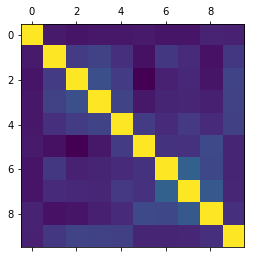

In [63]:
# Plot 1
corr = dft.corr()
plt.matshow(corr)
plt.show()

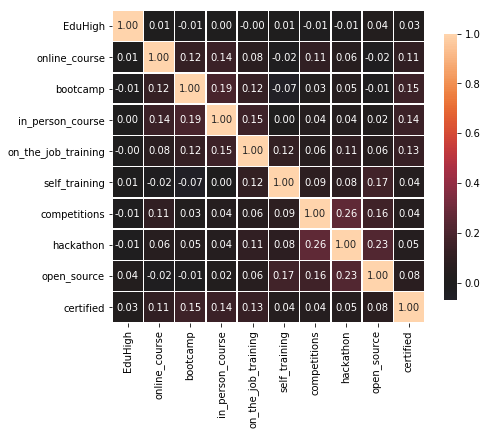

In [64]:
# Plot 2
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

We can see that there is almost no correlation between EduHigh variable and other variables. The highest values is 4% (with open_source feature).

### Distribution

In [65]:
stat = dft.groupby(by='EduHigh').sum()
stat

,online_course,bootcamp,in_person_course,on_the_job_training,self_training,competitions,hackathon,open_source,certified
EduHigh,,,,,,,,,
0,36049,9312,11249,23775,51462,15546,15885,24098,8693
1,13570,3307,4156,8763,19130,5555,5719,9834,3716


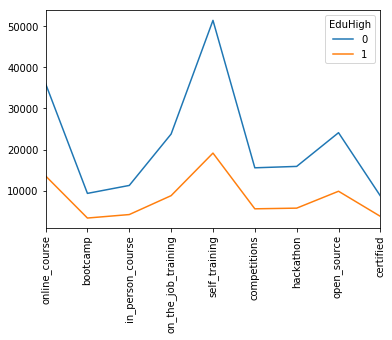

In [66]:
stat.T.plot()
plt.xticks(rotation=90);

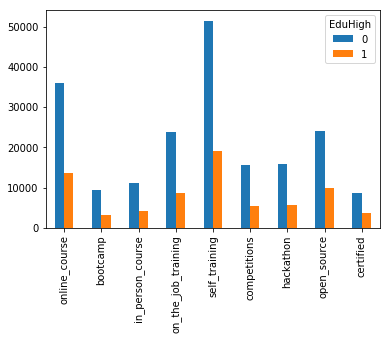

In [67]:
stat.T.plot(kind='bar')
plt.xticks(rotation=90);

Very indicative graph! The distribution is very similar for both formal education groups.

In [68]:
# Let's check the shares inside each group:
stat2 = dft.groupby(by='EduHigh').sum().T
stat2 = stat2.rename(columns={0: 'low', 1: 'high'})
stat2['low_share'] = stat2['low']/((dft['EduHigh'] == 0).sum())
stat2['high_share'] = stat2['high']/((dft['EduHigh'] == 1).sum())
stat2

EduHigh,low,high,low_share,high_share
online_course,36049,13570,0.598652,0.610052
bootcamp,9312,3307,0.154641,0.148669
in_person_course,11249,4156,0.186808,0.186837
on_the_job_training,23775,8763,0.394822,0.393949
self_training,51462,19130,0.854609,0.860007
competitions,15546,5555,0.258166,0.249730
hackathon,15885,5719,0.263796,0.257103
open_source,24098,9834,0.400186,0.442097
certified,8693,3716,0.144361,0.167056


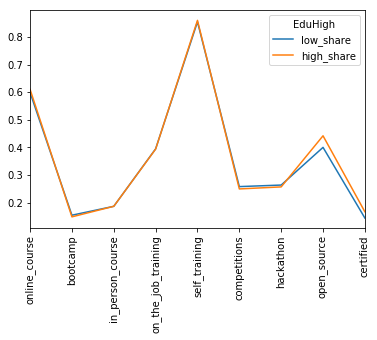

In [69]:
stat2[['low_share', 'high_share']].plot()
plt.xticks(rotation=90);

This graph confirms our finding: the distribution of non-formal education programs inside both groups of formal education is actually the same.

## Conclusion

There is no correlation whatsoever between the education level aggregated into two major groups, low and high education, and non-degree education. The both groups behave as a single non-categorized homogeneous group.

# QUESTION 3

We want to predict the salary using the "moderate quantity" of variables that we'll find significant for the salary prediction. By the "moderate quantity" we mean any quantity that is substantially lower than the one from the Udacity lesson case where more than 1000 variables were used reaching the test R2 score about 0.7. Our goal will be *to obtain similar result with less variables*.


We'll limit the number of variables by the following filters:
- the number of countries we'll be limited to **top (n) countries** where top (n) means the countries with most rows in our data set;
- we'll keep focus on **basic info**, **demography**, and **education and career** features;
- the **"list"** type of data where string values are concatenated will be discarded in order to simplify our data preprocessing work.

## Global variables

In [6]:
# label column (salary)
label = 'ConvertedComp'

# number of countries
max_countries = 50 #alternative = 15

## Common functions

In [7]:
df[label].describe()

count    5.582300e+04
mean     1.271107e+05
std      2.841523e+05
min      0.000000e+00
25%      2.577750e+04
50%      5.728700e+04
75%      1.000000e+05
max      2.000000e+06
Name: ConvertedComp, dtype: float64

In [8]:
def unique(df, col):
    '''
    Get list of unique values with count data.
    
    INPUT
    df - pandas dataframe
    col - column name
    
    OUTPUT
    unique values in the column
    '''         
    return df[col].value_counts()


def unique_plus_nan(df, col):
    '''
    Get list of unique values with count and percentage data, including NaN
    
    INPUT
    df - pandas dataframe
    col - column name
    
    OUTPUT
    unique values in the column including NaN, with count and percentage data
    '''            
    counts = df[col].value_counts()
    ii = counts.index.tolist()
    ii.append('NaN')
    vv = counts.values.tolist()
    vv.append(df[col].isnull().sum())
    
    r = pd.DataFrame({
        'value': ii,
        'count': vv
    }) 

    r['percentage'] = round(r['count']/len(df) * 100, 2)
    
    return r.reindex(columns=['value', 'count', 'percentage'])


def encode(df, col):
    '''
    Encode the column values using dummies.
    
    INPUT
    df - pandas dataframe
    col - column name
    
    OUTPUT
    encoded pandas dataframe
    '''               
    return df[col].str.get_dummies()


def check_missing(s):
    '''
    Calculates count/percentage of missing values.
    
    INPUT
    s - pandas series
    
    OUTPUT
    pandas dataframe with count/percentage data of missing values
    '''                   
    return {
        'count': s.isnull().sum(),
        'percentage': (s.isnull()).sum()/len(s)
    }


def plot_bar(data, col='Salary', width=15):
    '''
    Visualize data using bar plot.
    
    INPUT
    data - pandas dataframe
    col - column name to appear in the plot
    width - width of the plot area
    
    OUTPUT
    bar plot visualization
    '''            
    plt.xticks([1],[col])    
    data.plot(kind='bar', facecolor='peru', figsize=(width, 5))    
    plt.show()

    
def plot_hist(data, col='Salary', bins=10, cumulative=False, range=(0, 2000000)):
    '''
    Visualize data using histogram.
    
    INPUT
    data - pandas dataframe
    col - column name to appear in the plot
    bins - number of bins
    cumulative - True for the cumulative histogram or False for non-cumulative
    range - data range definition
    
    OUTPUT
    histogram visualization
    '''                
    print(data.isin(range).shape)
    plt.figure(figsize = (15,5))
    plt.xticks([1],[col])    
    plt.hist(data[data.notnull()],
             facecolor='peru',
             edgecolor='white',
             bins=bins,
             range=range,
             cumulative=cumulative)
    plt.show()    
    
    
def plot_dist(data, fit=norm, kde=False):
    '''
    Visualize data using seaborn histogram.
    
    INPUT
    data - pandas dataframe
    fit - fit distribution to (default: normal distribution) which plots 
    the normal distribution curve
    kde - whether to plot a gaussian kernel density estimate
    
    OUTPUT
    seaborn histogram visualization
    '''                    
    plt.figure(figsize=(15,5))
    sns.distplot(data.dropna(), fit=fit, kde=kde)
    
    
def plot_box(data, col='Salary', xticks_ixs=[1], xticks_lbls=['Salary'] ):
    '''
    Visualize data using boxplot.
    
    INPUT
    data - pandas dataframe
    col - column name to appear in the plot
    xticks_ixs - list of tick locations 
    xticks_lbls -list of tic labels
    
    OUTPUT
    plotbox visualization
    '''                        
    plt.figure(figsize = (5,15))
    plt.boxplot(data)
    plt.xticks(xticks_ixs,xticks_lbls)
    plt.show()    
    
    
def plot_correlation_matrix(data, size=(0,0)):
    '''
    Visualize data using correlation matrix.
    
    INPUT
    data - pandas dataframe
    size - size of the plot area
    
    OUTPUT
    correlation matrix visualization
    '''                    
    if size == (0,0):
        if data.shape[1] < 4:
            size = (5,5)
        elif data.shape[1] < 8:
            size = (7,7)
        else:
            size = (9,9)
    corr = data.corr()
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();    

    
def plot_correlation_matrix_cat(data, col, size=(0,0)):  
    '''
    Visualize categorical data using correlation matrix.
    
    INPUT
    data - pandas dataframe
    col - column with categorical data
    size - size of the plot area
    
    OUTPUT
    correlation matrix visualization
    '''                 
    data_cm = pd.concat([data[label], encode(data, col)], axis=1)
    plot_correlation_matrix(data_cm, size)    
    
    
def salary_stat(data, col, ascending=True):
    '''
    Calculate the average salary and the standard deviation for every value 
    in a given feature.
    
    INPUT
    data - pandas dataframe
    col - column with categorical data
    ascending - whether the values in a result set are sorted by ascending 
    or descending order
    
    OUTPUT
    pandas series with sorted values by mean
    '''             
    return data.groupby(by=col)[label].mean().sort_values(ascending=ascending)


def missing_stat(data):   
    '''
    Calculate the missing values statistic.
    
    INPUT
    data - pandas dataframe
    
    OUTPUT
    pandas dataframe with count/percentage data for every column
    '''                 
    stat = pd.DataFrame({
            'count': data.isnull().sum(),
            'percentage': round(data.isnull().sum()/data.shape[0] * 100, 2)
        })  
    print(stat.sort_values(by='percentage', ascending=False))
    print('-------------------------------------------------')
    # count total number of rows that have at least one missing value
    missing_count = 100 - data.dropna(how='any', axis=0).shape[0]/len(data) * 100 
    print(f'Total missing rows: {round(missing_count, 2)}%')  
    print('-------------------------------------------------')


## Label: Salary (ConvertedComp)

  - description: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
  - type: categorical

### Missing values

In [9]:
missing_salaries = check_missing(df[label])
print(missing_salaries)
print(f"Dataset size without missing labels: {len(df) - missing_salaries['count']}")

{'count': 33060, 'percentage': 0.3719496416637602}
Dataset size without missing labels: 55823


#### Remove the missing labels

If we remove the missing labels we will remove 37% of all rows. Will the remaining data  be enough to create a non-overfitted predicition model with good accuracy? 

Although we also risk that by removing the missing labels we'll remove or distort some hidden relationships between missing labels and some other predictors we opt for removing the missing labels.

In [10]:
data = df.dropna(subset=[label], axis=0)
data.shape

(55823, 85)

### Outliers

(55823,)


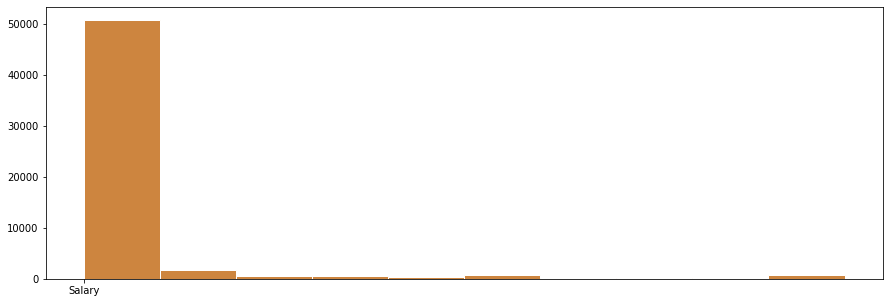

In [11]:
plot_hist(data[label], bins=10)

(55823,)


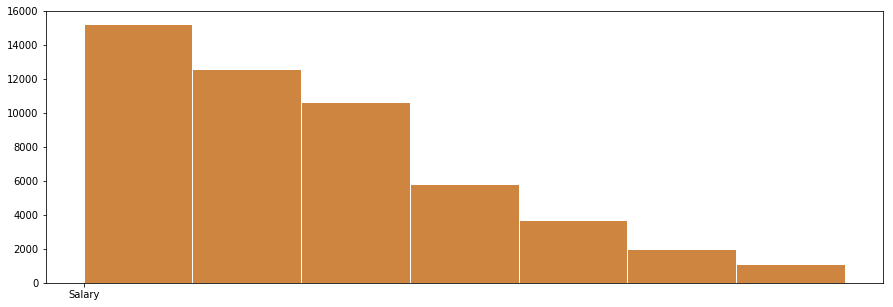

In [582]:
plot_hist(data[label], bins=7, range=(0, 200000))

(55823,)


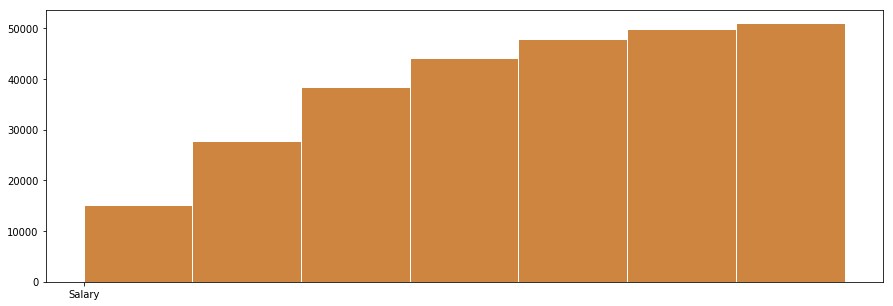

In [583]:
plot_hist(data[label], bins=7, range=(0, 200000), cumulative=True)

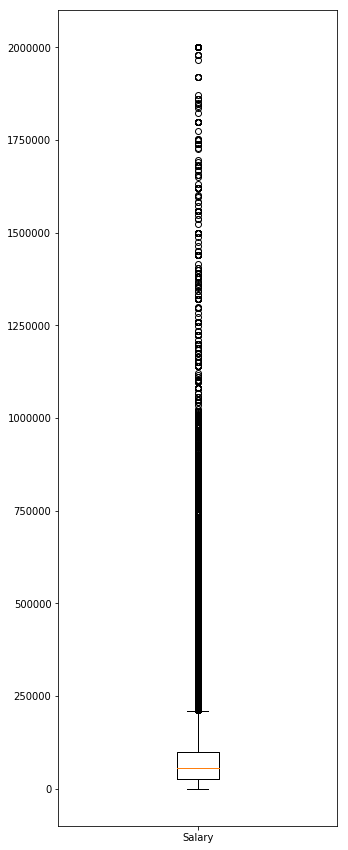

In [584]:
plot_box(data[label])

We can see the outliers from around 250.000 USD. Let's find the threshold.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


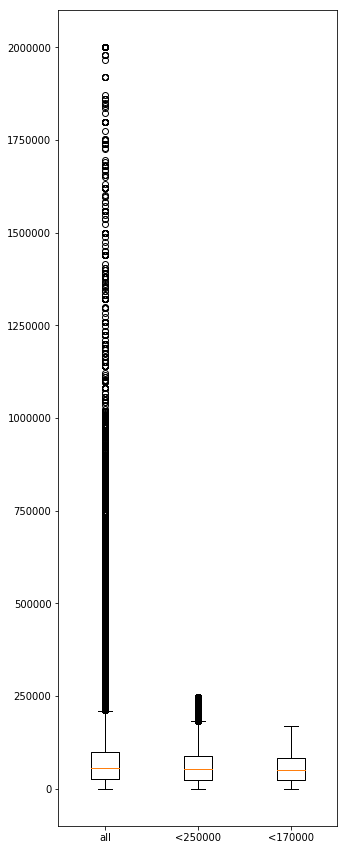

In [585]:
plot_box([data[label], data[data[label] < 250000][label], data[data[label] < 170000][label]],
        xticks_ixs=[1,2,3], xticks_lbls=['all', '<250000', '<170000'])

So the threshold is about 170.000 USD. Then we'll filter our data leaving out the salaries above 170.000 USD.

In [12]:
# Filter by MAX salary
data = data[data[label] < 170000]
data.shape

(49741, 85)

## Variable Selection (Data Preprocessing)

Let's check how our data is classified on the *section level*.

In [13]:
unique(schema2, 'Section')

Education, Work, Career    36
Tect and tech Culture      21
Stack Overflow             13
Demographics                8
Basic Info                  7
Name: Section, dtype: int64

We'll discard the **Tect and tech culture** and **Stack Overflow** section since our focus is on other sections. By discarding these two sections we don't want to suggest that these features are of no relevance. We are aware that this initial reducation can cut off some significant features that may lay in the excluded sections but, again, our purpose is to dig in the field of other features.

In [587]:
schema2[schema2['Section'] == 'Tect and tech Culture']

,Column,Section,QuestionText
43,LanguageWorkedWith,Tect and tech Culture,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
44,LanguageDesireNextYear,Tect and tech Culture,"Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)"
45,DatabaseWorkedWith,Tect and tech Culture,"Which of the following database environments have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the database and want to continue to do so, please check both boxes in that row.)"
46,DatabaseDesireNextYear,Tect and tech Culture,"Which of the following database environments have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the database and want to continue to do so, please check both boxes in that row.)"
47,PlatformWorkedWith,Tect and tech Culture,"Which of the following platforms have you done extensive development work for over the past year? (If you both developed for the platform and want to continue to do so, please check both boxes in that row.)"
48,PlatformDesireNextYear,Tect and tech Culture,"Which of the following platforms have you done extensive development work for over the past year? (If you both developed for the platform and want to continue to do so, please check both boxes in that row.)"
49,WebFrameWorkedWith,Tect and tech Culture,"Which of the following web frameworks have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)"
50,WebFrameDesireNextYear,Tect and tech Culture,"Which of the following web frameworks have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)"
51,MiscTechWorkedWith,Tect and tech Culture,"Which of the following other frameworks, libraries, and tools have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the technology and want to continue to do so, please check both boxes in that row.)"
52,MiscTechDesireNextYear,Tect and tech Culture,"Which of the following other frameworks, libraries, and tools have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the technology and want to continue to do so, please check both boxes in that row.)"


In [588]:
schema2[schema2['Section'] == 'Stack Overflow']

,Column,Section,QuestionText
64,SOVisit1st,Stack Overflow,"To the best of your memory, when did you first visit Stack Overflow?"
65,SOVisitFreq,Stack Overflow,How frequently would you say you visit Stack Overflow?
66,SOVisitTo,Stack Overflow,I visit Stack Overflow to... (check all that apply)
67,SOFindAnswer,Stack Overflow,"On average, how many times a week do you find (and use) an answer on Stack Overflow?"
68,SOTimeSaved,Stack Overflow,"Think back to the last time you solved a coding problem using Stack Overflow, as well as the last time you solved a problem using a different resource. Which was faster?"
69,SOHowMuchTime,Stack Overflow,"About how much time did you save? If you're not sure, please use your best estimate."
70,SOAccount,Stack Overflow,Do you have a Stack Overflow account?
71,SOPartFreq,Stack Overflow,"How frequently would you say you participate in Q&A on Stack Overflow? By participate we mean ask, answer, vote for, or comment on questions."
72,SOJobs,Stack Overflow,Have you ever used or visited Stack Overflow Jobs?
73,EntTeams,Stack Overflow,Have you ever used Stack Overflow for Enterprise or Stack Overflow for Teams?


The features of our interest lay in the remaining three sections:
- **Basic Info**
- **Demographics**
- **Education, Work, Career**

We'll calculate the *correlation coefficients* which we'll be used as a criteria to preselect the columns. We'll write a function that will check the coefficients of all features of a given column/section and will isolate **the max coefficient**. If the max coefficient is about **10% or higher**, the column is taken into further examination. We count on that if the max coefficient is above a certain value which we consider as "high" than there must be some features of the column that can be significant for our prediction task. 

In [14]:
# Define column data type in order to execute further column preselection accordingly

def define_column_dtype(data):
    '''
    Defines data type for each column.
    
    INPUT
    data - pandas dataframe
    
    OUTPUT
    pandas dataframe with the column name and dtype with the following values:
        - number: number type (int, float)
        - numeric: number with some strings
        - string: string values
        - list: concatenated strings with comma delimiter
    '''             
    result = []
    numerics = ['YearsCode', 'Age1stCode', 'YearsCodePro']
    for col in data.columns:
        if col in data.select_dtypes(include=['number']).columns:
            result.append({'column': col, 'dtype': 'number'})
        elif col in numerics:
            result.append({'column': col, 'dtype': 'numeric'})            
        elif data[col].str.find(';').value_counts().shape[0] > 1:
            result.append({'column': col, 'dtype': 'list'})
        else:
            result.append({'column': col, 'dtype': 'string'})
        
    return pd.DataFrame(result)


# store columns data types into global variable
columns_info = define_column_dtype(data)
# exclude label column
columns_info = columns_info[columns_info.column != label]  

In [15]:
# Functions to support column preselection

def calc_corr(data, col):
    '''
    Calculate correlation coefficient for the given column and the salary column.
    
    INPUT
    data - pandas dataframe
    col - column
    
    OUTPUT
    corr_max - max correlation coefficient for a given col
    column_info - column data type info
    '''             
    # prepare data2 according to the data type
    column_info = columns_info[columns_info.column == col]
    if column_info.dtype.iloc[0] == 'number':
        data2 = pd.concat([data[label], data[col]], axis=1)
    elif column_info.dtype.iloc[0] == 'numeric':
        ndata = data[data[col].apply(lambda x: str(x).isnumeric())][col]\
            .apply(lambda x: int(x))   
        data2 = pd.concat([data[label], ndata], axis=1)
    elif column_info.dtype.iloc[0] == 'string':
        data2 = pd.concat([data[label], encode(data, col)], axis=1)
    # skip list dtype
    else:
        return 0, column_info.dtype.iloc[0]
        
    corr = data2.corr()
    
    # return the highest (positive) correlation coefficient 
    corr_max = float(corr[corr.index != label][label] \
                 .sort_values(ascending=False).head(1))
    
    return corr_max, column_info.dtype.iloc[0]


def calc_section_corr(data, section, cols=[]):
    '''
    Calculate the highest correlation coefficient for every column in 
    a given section together with the salary column.
    
    INPUT
    data - pandas dataframe
    section - data section
    cols - list of column (if not given then all column of data section 
    will  be used)
    
    OUTPUT
    pandas dataframe with columns and their coefficients
    '''             
    if cols == []:
        cols = schema2[(schema2['Section'] == section)\
                       & (schema2['Column'] != label)]['Column']
    
    dtypes = []
    coeffs = []
    for col in cols:    
        coef, dtype = calc_corr(data, col)
        dtypes.append(dtype)
        coeffs.append(coef)
     
    stat = pd.DataFrame({'column': cols, 'dtype': dtypes, 'coefficient': coeffs})
     
    return stat[['column', 'dtype', 'coefficient']].reset_index().drop('index', axis=1) \
        .sort_values(by='coefficient', ascending=False)


### Section: Basic Info

In [16]:
schema2[schema2['Section'] == 'Basic Info']

,Column,Section,QuestionText
0,Respondent,Basic Info,Randomized respondent ID number (not in order of survey response time)
1,MainBranch,Basic Info,"Which of the following options best describes you today? Here, by 'developer' we mean 'someone who writes code.'"
2,Hobbyist,Basic Info,Do you code as a hobby?
3,OpenSourcer,Basic Info,How often do you contribute to open source?
4,OpenSource,Basic Info,How do you feel about the quality of open source software (OSS)?
5,Employment,Basic Info,Which of the following best describes your current employment status?
6,Country,Basic Info,In which country do you currently reside?


In [17]:
calc_section_corr(data, 'Basic Info')

,column,dtype,coefficient
6,Country,string,0.556643
5,Employment,string,0.094383
4,OpenSource,string,0.053798
3,OpenSourcer,string,0.036667
2,Hobbyist,string,0.010653
1,MainBranch,string,0.007403
0,Respondent,number,-0.000954


Preselected columns: **Country**, **Employment**

### Section: Demographics

In [598]:
calc_section_corr(data, 'Demographics')

,column,dtype,coefficient
0,Age,number,0.393865
6,SurveyLength,string,0.108270
7,SurveyEase,string,0.106064
5,Dependents,string,0.058745
2,Trans,string,0.024657
1,Gender,list,0.000000
3,Sexuality,list,0.000000
4,Ethnicity,list,0.000000


Preselected columns: **Age**, **Gender**. We'll examine further the *Gender* feature (which has been primarily excluded as "list" type), the gender as a feature has a certain attractivness and we want to dig a little bit more in it. The *SurveyLength* and *SurveyEase* are ruled out, we can't see any significant correlation between these two features and the salary.

### Section: Education, Work, Career

In [595]:
calc_section_corr(data, 'Education, Work, Career')

,column,dtype,coefficient
21,CurrencyDesc,string,0.516269
20,CurrencySymbol,string,0.516269
23,CompFreq,string,0.496898
6,YearsCode,numeric,0.399105
8,YearsCodePro,numeric,0.380892
0,Student,string,0.251645
9,CareerSat,string,0.181868
30,CodeRev,string,0.160966
32,UnitTests,string,0.157298
10,JobSat,string,0.156580


Preselected columns: **CompFreq**, **YearsCode**, **Student**, **CareerSat**, **CodeRev**, **UnitTests**, **JobSat**, **LastHireDate**, **JobSeek**, **OrgSize**, **ImpSyn**, **FizzBuzz**, **WorkRemote**. We'll also check **EdLevel** column. The *CurrencyDesc* and *CurrencySymbol* are ruled out, they are related to the *CompTotal* feature but since we use *ConvertedComp* as the salary feature, all other salary features can be eliminated. 

So our preselected column are:
- Country 
- Employment 
- Age
- Gender
- EdLevel
- CompFreq 
- YearsCode 
- YearsCodePro 
- Student 
- CareerSat 
- CodeRev 
- UnitTests 
- JobSat 
- LastHireDate 
- JobSeek 
- ImpSyn 
- OrgSize 
- FizzBuzz 
- WorkRemote

In [97]:
# TODO

# Preselected columns
cols = [
    'Country', 
    'Employment', 
    'Age', 
    'EdLevel',
    'YearsCode', 
    'YearsCodePro', 
    'Student', 
    'CareerSat', 
    'CodeRev', 
    'UnitTests', 
    'JobSat', 
    'LastHireDate', 
    'JobSeek', 
    'ImpSyn', 
    'OrgSize', 
    'FizzBuzz', 
    'WorkRemote']
variables = columns_info[columns_info.column.isin(cols)]
variables

#cols = [
#    'Student', 'EdLevel', 'UndergradMajor', 'OrgSize', 'YearsCode', 'CareerSat', 'ResumeUpdate',
#    'JobSat', 'MgrIdiot', 'MgrMoney', 'MgrWant', 'JobSeek', 'LastHireDate', 'FizzBuzz', 
#    'WorkPlan', 'WorkLoc', 'ImpSyn', 'CodeRev', 'UnitTests', 'PurchaseHow', 'PurchaseWhat'
#]

,column,dtype
5,Employment,string
6,Country,string
7,Student,string
8,EdLevel,string
11,OrgSize,string
13,YearsCode,numeric
15,YearsCodePro,numeric
16,CareerSat,string
17,JobSat,string
21,JobSeek,string


Let us now more closely examine each of the preselected columns.

## Variable: Country

  - description: respondent's country
  - type: categorical
  - values count: 159

In [137]:
unique(data, 'Country').shape[0]

159

We'll reduce the total number of coutries (159) to top 50 countries with most data rows (top countries). Consequently, our predicition model will be limited to the countries from the list of top countries.

In [19]:
# Top countries
countries = list(data['Country'].value_counts().head(max_countries).index)
countries

['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'France',
 'Brazil',
 'Poland',
 'Netherlands',
 'Russian Federation',
 'Australia',
 'Spain',
 'Sweden',
 'Italy',
 'Switzerland',
 'Israel',
 'Ukraine',
 'Turkey',
 'Austria',
 'Czech Republic',
 'Mexico',
 'Belgium',
 'Pakistan',
 'Iran',
 'Romania',
 'South Africa',
 'Bulgaria',
 'Denmark',
 'Argentina',
 'Finland',
 'Norway',
 'Portugal',
 'Hungary',
 'New Zealand',
 'Greece',
 'Ireland',
 'Bangladesh',
 'Japan',
 'China',
 'Serbia',
 'Indonesia',
 'Colombia',
 'Slovenia',
 'Nigeria',
 'Sri Lanka',
 'Croatia',
 'Lithuania',
 'Philippines',
 'Egypt',
 'Slovakia']

In [85]:
# Check the shape before and after the reduction
print(f'all countries: {data.shape[0]}')
print(f'top countries: {data[data["Country"].isin(countries)].shape[0]}')

all countries: 49741
top countries: 46394


In [20]:
# Reduce data to top countries
data = data[data['Country'].isin(countries)]
data.shape

(46394, 85)

In [21]:
# Calc salary mean for every country from the list 
salary_stat(data, col='Country', ascending=False)

Country
United States         97125.556614
Israel                84498.902703
Switzerland           84221.099650
Denmark               81599.030457
Norway                78903.495775
Australia             76388.450281
Ireland               74360.462745
Canada                68298.456681
United Kingdom        65754.850259
New Zealand           65203.646688
Germany               60574.212113
Netherlands           59174.474592
Sweden                58281.013793
Finland               56308.690860
Belgium               54003.635135
Austria               53819.341667
Japan                 52792.661088
France                50125.806680
South Africa          43067.270471
Spain                 40856.304878
Slovenia              39494.707071
Czech Republic        38342.552301
Lithuania             38104.312500
Italy                 37810.097735
Poland                35476.899540
Romania               34607.292079
Slovakia              33950.657534
Bulgaria              32751.421717
China       

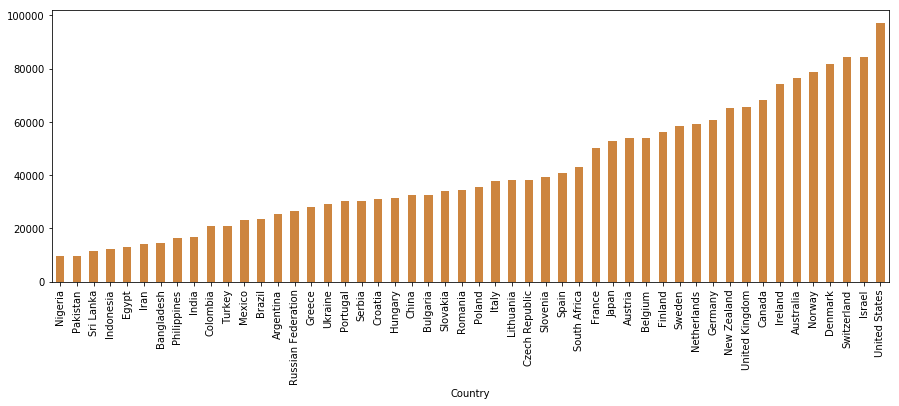

In [550]:
plot_bar(salary_stat(data, 'Country'))

We can see that the salary definetely depends on the country. You'll very likely not earn the same money as the developer if you work in Nigeria or if you work in the United States.

Let's check the salary label after making the data reduction:

(46394,)


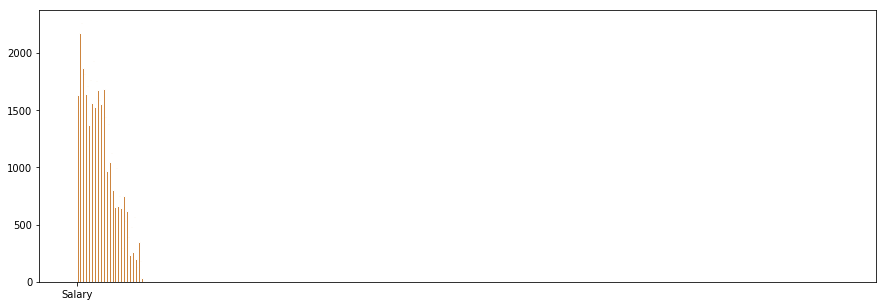

In [91]:
plot_hist(data[label], bins=500)

Let's try with seaborn:

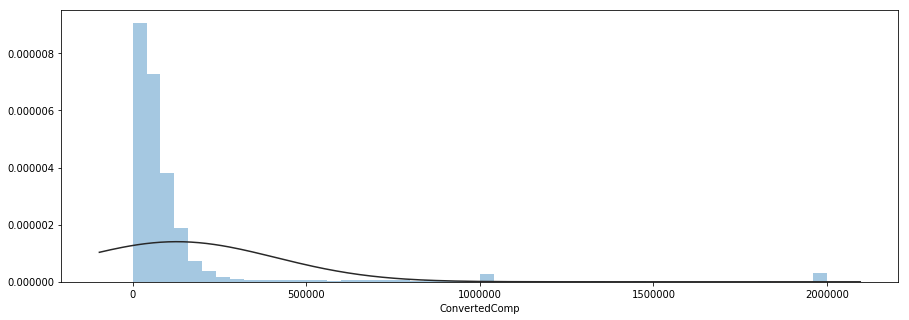

In [92]:
# Before the reduction:
plot_dist(df[label])

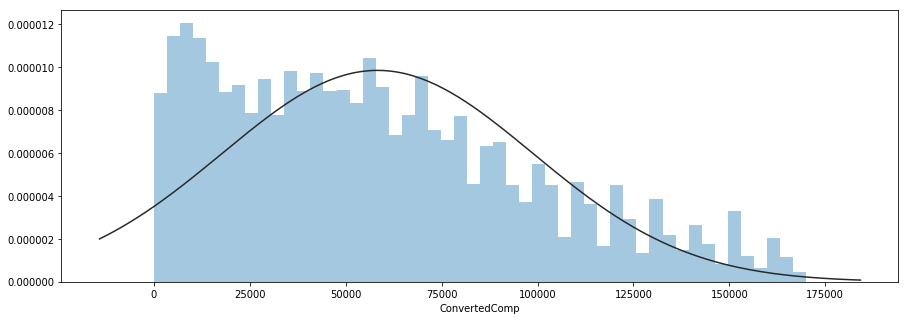

In [93]:
# After the reduction:
plot_dist(data[label])

We have cut the outliers and substantially narrowed the interval between min and max salary. It can be seen that the distribution of the salaries above 25.000 USD follows pretty well the normal distribution.

## Variable: Age

  - description: respondent's age
  - type: numerical
  - values count: 78

In [28]:
unique(data, 'Age').shape[0]

89

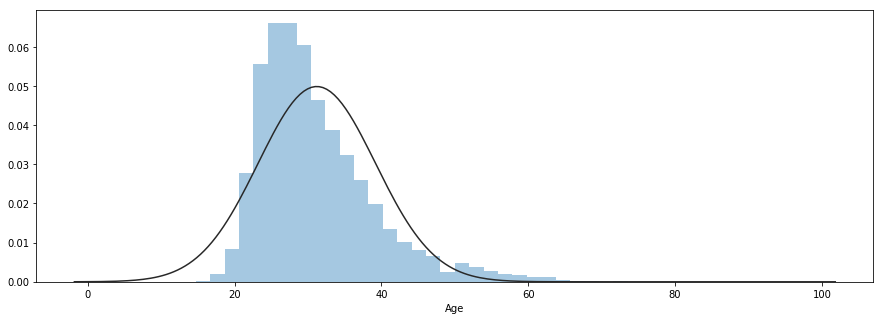

In [29]:
plot_dist(data.Age)

In [30]:
print(f"Average age: {round(data['Age'].mean())}")

Average age: 31


In [141]:
def get_agecat(age):
    '''
    Categorize the age feature.
    
    INPUT
    age - age value
    
    OUTPUT
    category from ['young', 'average', 'veteran'] 
    '''         
    if age < 26:
        return 'young'
    elif age < 36:
        return 'average'
    else:
        return 'veteran'
    
    
data['AgeCat'] = data.Age.apply(get_agecat)    

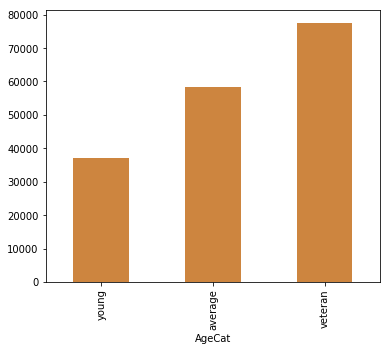

In [96]:
plot_bar(salary_stat(data, 'AgeCat'), width=6)

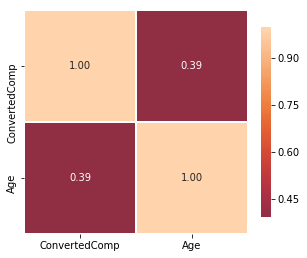

In [97]:
plot_correlation_matrix(data[[label, 'Age']])

It's evident that the age has impact on the salary. 

## Variable: YearsCodePro

  - description: years of professional coding
  - type: numeric with 2 string values
  - values count: 51

In [34]:
unique(data, 'YearsCodePro').shape[0]

51

In [22]:
def get_yearscodepro_num(val):
    '''
    Handle non-numeric values of the years of professional coding feature 
    converting them into numeric.
    
    INPUT
    val - numeric or non-numeric value
    
    OUTPUT
    numeric value 
    '''             
    if val == 'Less than 1 year':
        return 0
    elif val == 'More than 50 years':
        return 51
    else:
        return int(val)
    

def get_yearscodepro_cat(years):
    '''
    Categorize the years of professional coding feature.
    
    INPUT
    years - number of years of coding
    
    OUTPUT
    category from ['years-young', 'years-average', 'years-veteran'] 
    '''             
    years2 = get_yearscodepro_num(years)
    if years2 < 5:
        return 'years-young'
    elif years2 < 12:
        return 'years-average'
    else:
        return 'years-veteran'
    
    
data['YearsCodeProCat'] = data.YearsCodePro.dropna().apply(get_yearscodepro_cat)

In [75]:
# convert 'numeric' to 'number'
data['YearsCodePro'] = data['YearsCodePro'].dropna().apply(get_yearscodepro_num)

In [76]:
data['YearsCodePro'].mean()

7.75639806328895

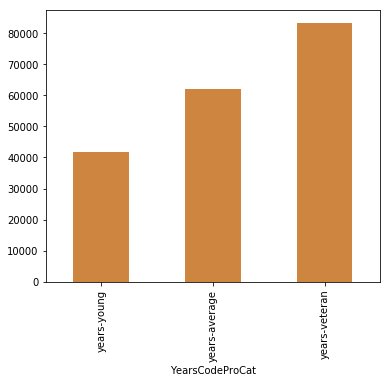

In [144]:
plot_bar(salary_stat(data, 'YearsCodeProCat'), width=6)

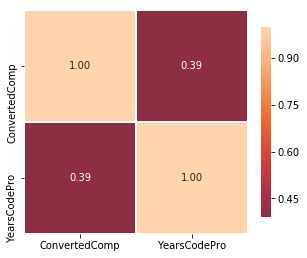

In [77]:
plot_correlation_matrix(data[[label, 'YearsCodePro']])

The column is confirmed as selected.

## Variable: Gender (INSIGNIFICANT)

  - description: respondent's gender
  - type: categorical
  - values count: 7

In [78]:
unique(data, 'Gender')

Man                                                            41884
Woman                                                           3230
Non-binary, genderqueer, or gender non-conforming                283
Man;Non-binary, genderqueer, or gender non-conforming             99
Woman;Non-binary, genderqueer, or gender non-conforming           94
Woman;Man                                                         36
Woman;Man;Non-binary, genderqueer, or gender non-conforming       18
Name: Gender, dtype: int64

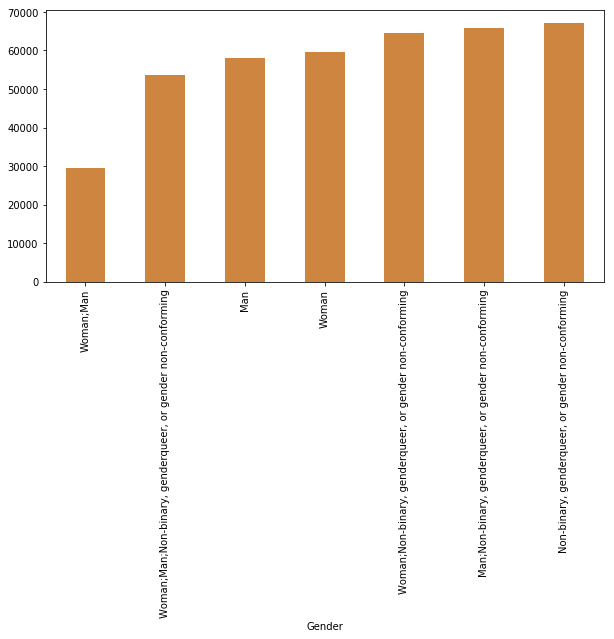

In [43]:
plot_bar(salary_stat(data, 'Gender'), width=10)

In [104]:
print(f"Percentage of respondents declared as 'Man' or 'Woman': \
{data['Gender'].isin(['Man', 'Woman']).sum()/len(data) * 100}")

Percentage of respondents declared as 'Man' or 'Woman': 97.24102254601888


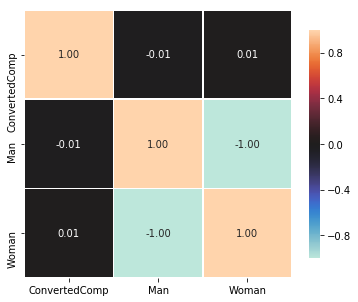

In [45]:
plot_correlation_matrix_cat(data[data['Gender'].isin(['Man', 'Woman'])], 'Gender', size=(6,6))

If we evaluate only the gender categories 'Man' and 'Woman' (97%), then we can't see significant difference between the sexes relating to their salary. So we'll discard the Gender feature as insignificant. 

## Variable: Student

  - description: is the respondent a student?
  - type: categorical
  - values count: 3

In [46]:
unique(data, 'Student')

No                39054
Yes, full-time     4263
Yes, part-time     2796
Name: Student, dtype: int64

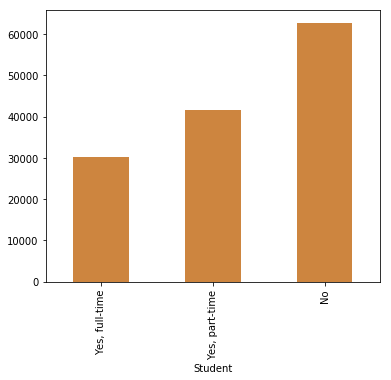

In [47]:
plot_bar(salary_stat(data, 'Student'), width=6)

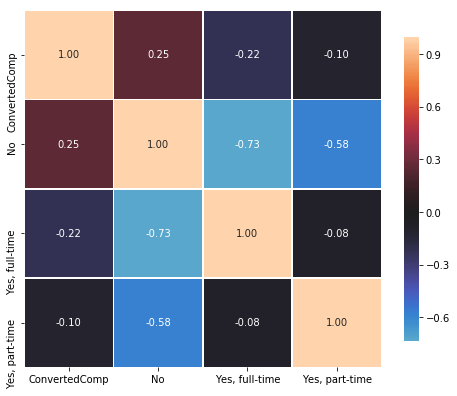

In [105]:
plot_correlation_matrix_cat(data, 'Student', size=(8,8))

Without any doubt, it matters if you study or not.

## Variable: Employment

  - description: respondent's current employment status
  - type: categorical
  - values count: 3

In [49]:
unique(data, 'Employment')

Employed full-time                                      40856
Independent contractor, freelancer, or self-employed     3573
Employed part-time                                       1851
Name: Employment, dtype: int64

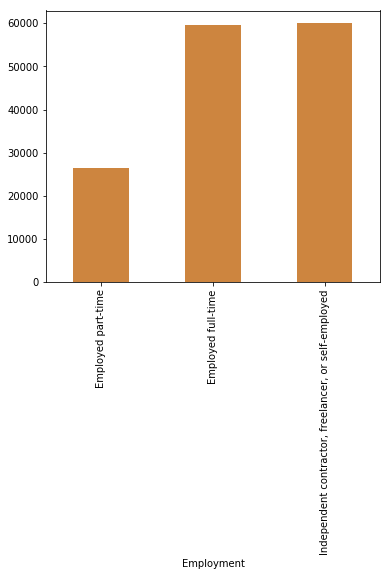

In [50]:
plot_bar(salary_stat(data, 'Employment'), width=6)

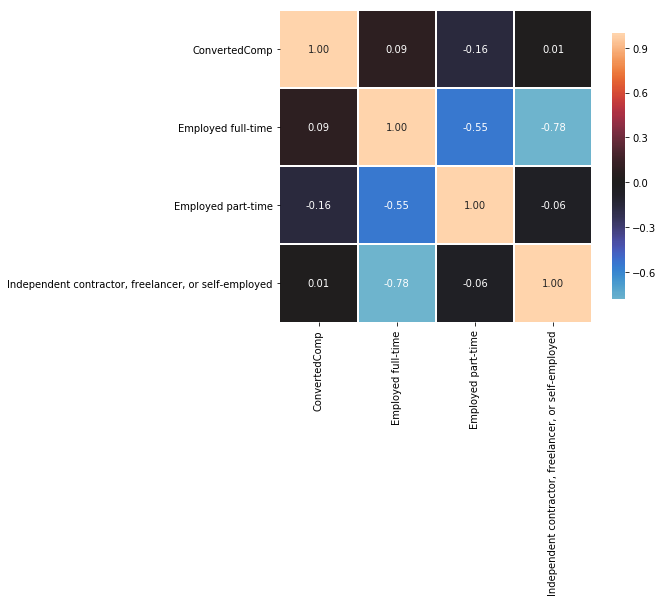

In [51]:
plot_correlation_matrix_cat(data, 'Employment')

Working part-time evidently affects the salary.

## Variable: EdLevel

  - description: respondent's formal education level
  - type: categorical
  - values count: 9

In [52]:
unique(data, 'EdLevel')

Bachelor’s degree (BA, BS, B.Eng., etc.)                                              22260
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           11635
Some college/university study without earning a degree                                 5443
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     2483
Associate degree                                                                       1582
Other doctoral degree (Ph.D, Ed.D., etc.)                                              1327
Professional degree (JD, MD, etc.)                                                      574
Primary/elementary school                                                               213
I never completed any formal education                                                  166
Name: EdLevel, dtype: int64

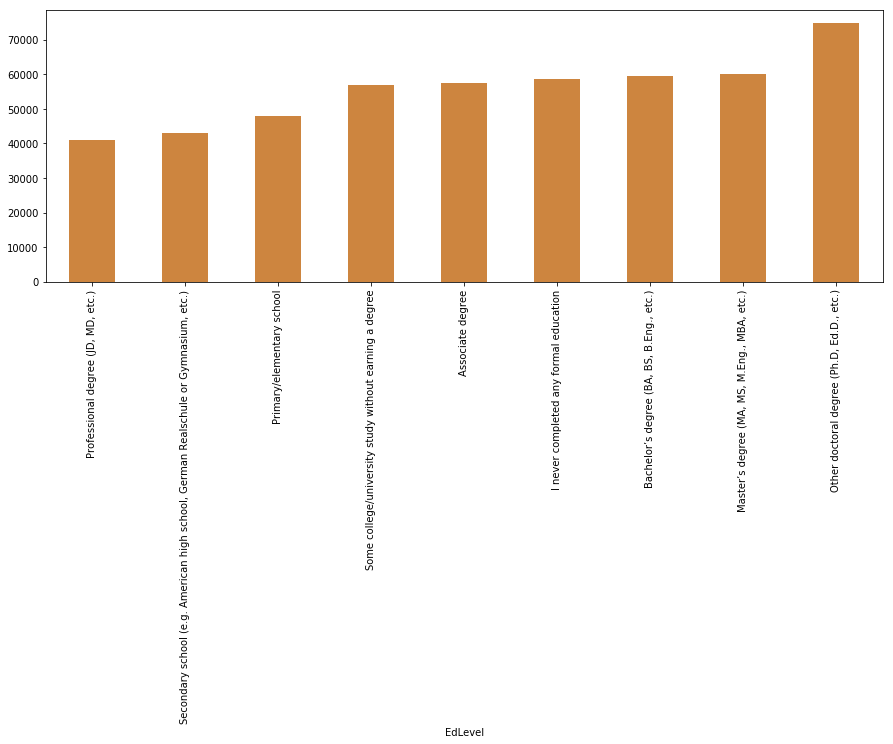

In [53]:
plot_bar(salary_stat(data, 'EdLevel'), width=15)

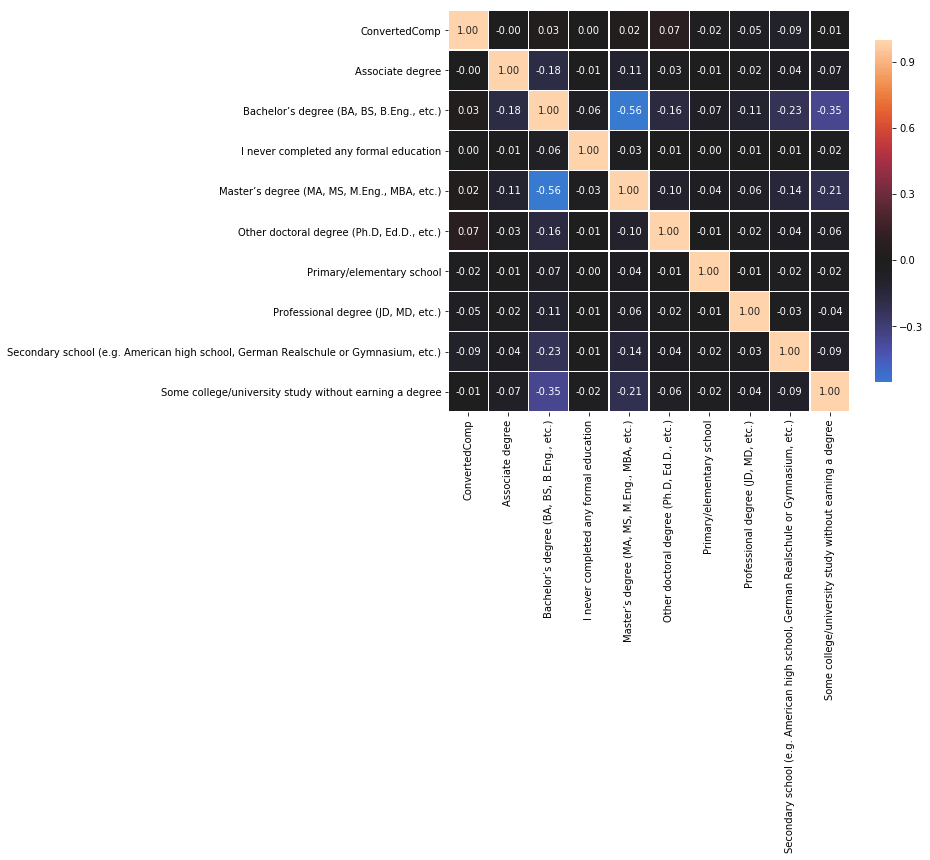

In [54]:
plot_correlation_matrix_cat(data, 'EdLevel')

In the both graphs we see that in some cases, higher the education level greater the salary. Although the correlation matrix hasn't quite confirmed this difference we'll keep the column.

## Variable: OrgSize

  - description: size of the company where the respondent is employed
  - type: categorical
  - values count: 9

In [57]:
unique(data, 'OrgSize')

20 to 99 employees                                    10233
100 to 499 employees                                   8595
10,000 or more employees                               6165
1,000 to 4,999 employees                               4858
10 to 19 employees                                     4427
2-9 employees                                          4424
500 to 999 employees                                   3059
5,000 to 9,999 employees                               1969
Just me - I am a freelancer, sole proprietor, etc.     1822
Name: OrgSize, dtype: int64

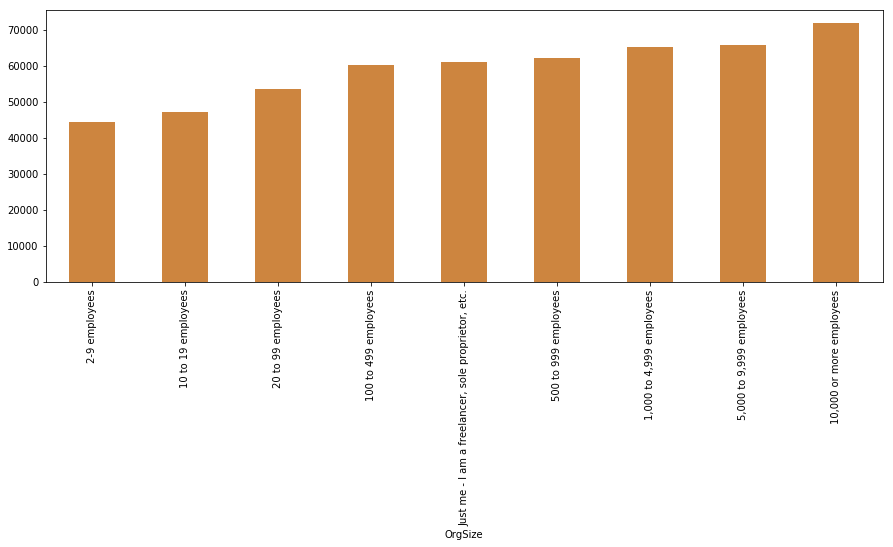

In [58]:
plot_bar(salary_stat(data, 'OrgSize'))

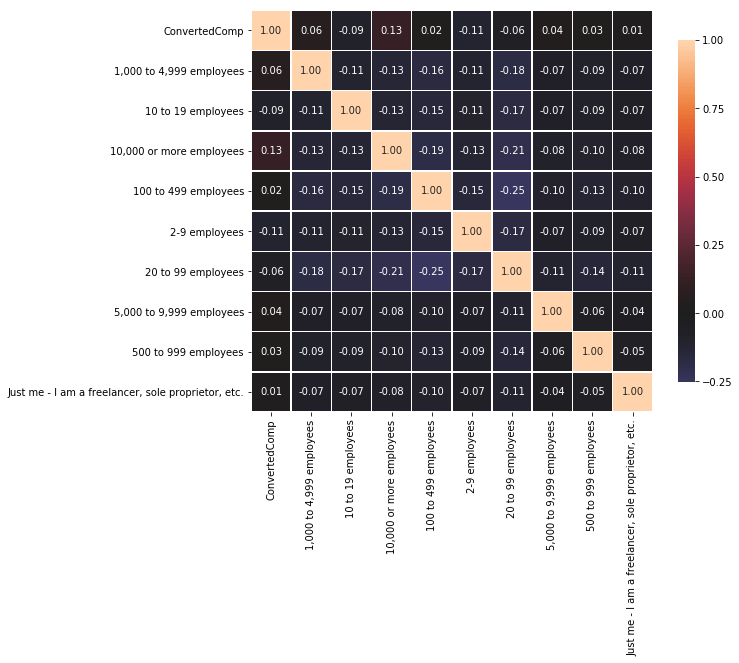

In [59]:
plot_correlation_matrix_cat(data, 'OrgSize')

The size of the company is in strict linear correlation with the salary (with the exception of the freelancer): bigger the company bigger the salary. 

## Variable: WorkRemote

  - description: How often do you work remotely?
  - type: categorical
  - values count: 7

In [60]:
unique(data, 'WorkRemote')

Less than once per month / Never                           20411
A few days each month                                      11750
All or almost all the time (I'm full-time remote)           5220
Less than half the time, but at least one day each week     4269
It's complicated                                            2000
More than half, but not all, the time                       1438
About half the time                                         1185
Name: WorkRemote, dtype: int64

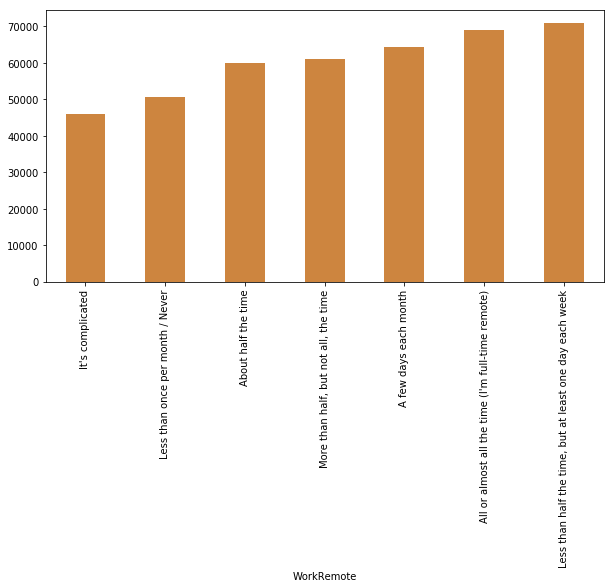

In [61]:
plot_bar(salary_stat(data, 'WorkRemote'), width=10)

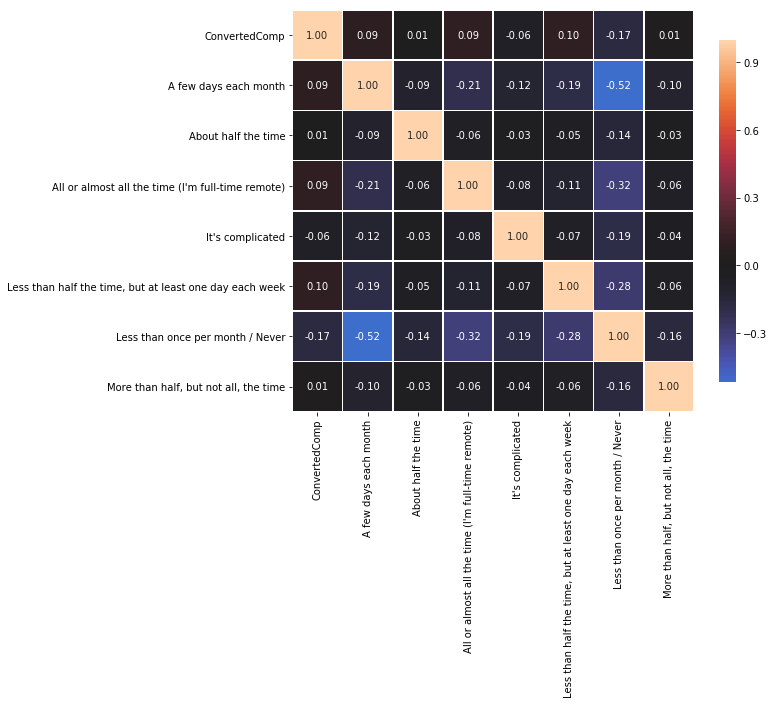

In [183]:
plot_correlation_matrix_cat(data, 'WorkRemote')   

Although not perfectly linearly, the remote work is in a certain relationship with the salary: the negative correlation of -16% is found in cases when the respondents work remotely less than once per month or never, and the positive correlation of 9-10% in cases when the respondents work less than half the time, full-time or almost all the time remotely. 

## Variable: ImpSyn

  - description: level of own compentence given by the respondent  
  - type: categorical
  - values count: 5

In [63]:
unique(data, 'ImpSyn')

A little above average    21487
Average                   10874
Far above average          9603
A little below average     3414
Far below average           914
Name: ImpSyn, dtype: int64

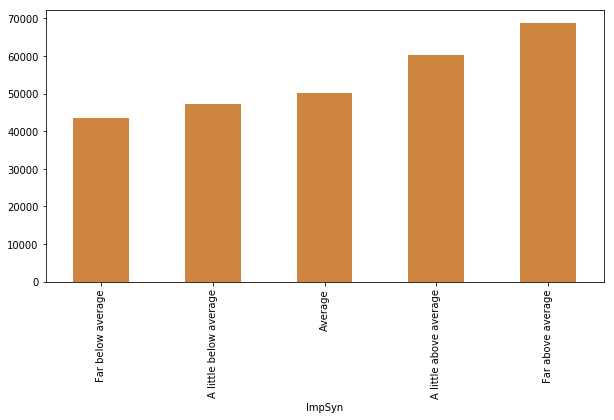

In [64]:
plot_bar(salary_stat(data, 'ImpSyn'), width=10)

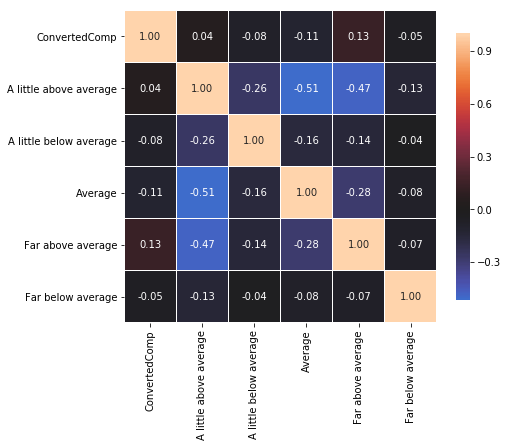

In [184]:
plot_correlation_matrix_cat(data, 'ImpSyn')  

We find very linear correlation between the own competence level and the salary: less compentent, lower the salary; more competent, higher the salary. 

## Variable: FizzBuzz

  - description: Have you ever been asked to solve FizzBuzz in an interview?
  - type: categorical
  - values count: 2

In [66]:
unique(data, 'FizzBuzz')

No     39220
Yes     6796
Name: FizzBuzz, dtype: int64

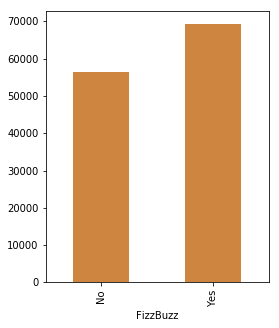

In [67]:
plot_bar(salary_stat(data, 'FizzBuzz'), width=4)

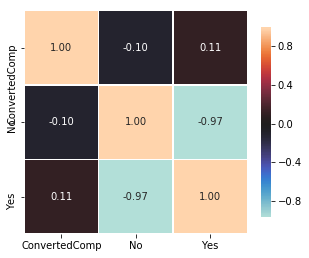

In [68]:
plot_correlation_matrix_cat(data, 'FizzBuzz')  

The FizzBuzz test is "a very simple programming task, used in software developer job interviews, to determine whether the job candidate can actually write code." (https://www.tomdalling.com/blog/software-design/fizzbuzz-in-too-much-detail/). It looks that if the respondent does the FizzBuzz test in the job interview it will have a greater salary than the respondent that doesn't do it.

## Other variables

#### Variable: YearsCode

In [82]:
# convert 'numeric' to 'number'
data['YearsCode'] = data['YearsCode'].dropna().apply(get_yearscodepro_num)

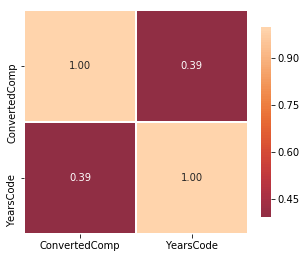

In [88]:
plot_correlation_matrix(data[[label, 'YearsCode']])

#### Variable: CareerSat

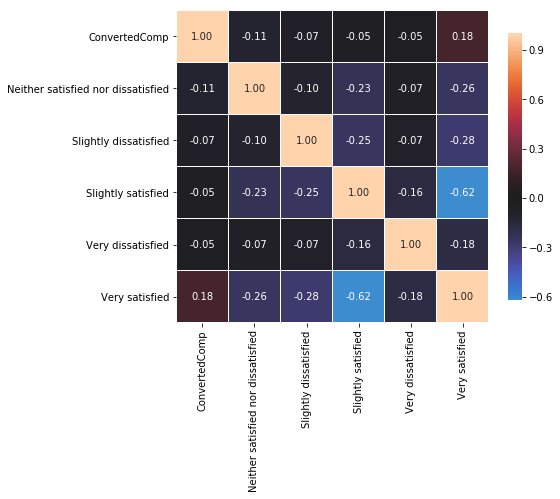

In [89]:
plot_correlation_matrix_cat(data, 'CareerSat')  

#### Variable: CodeRev

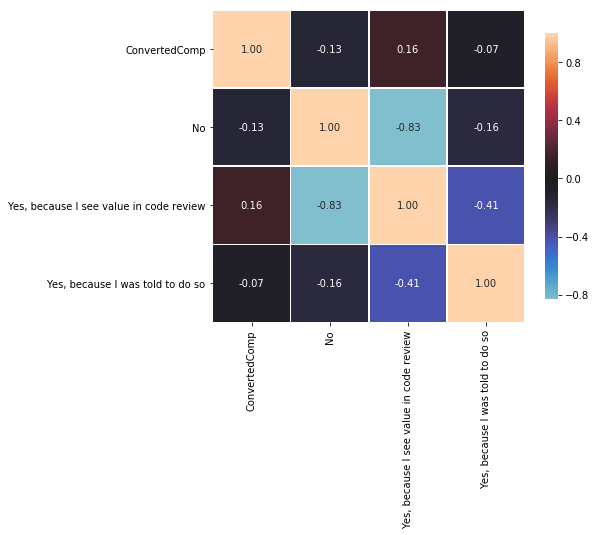

In [90]:
plot_correlation_matrix_cat(data, 'CodeRev')  

#### Variable: JobSat

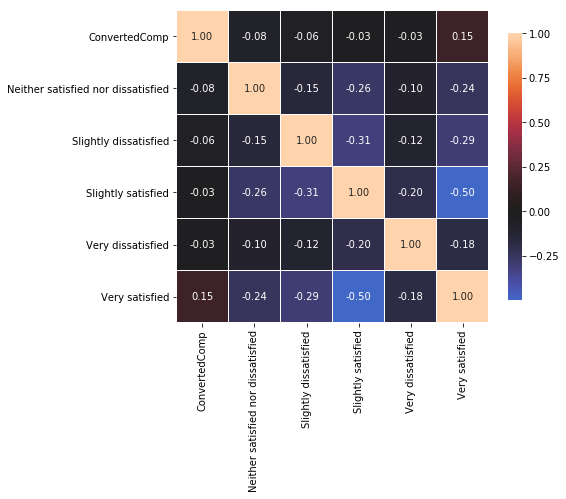

In [91]:
plot_correlation_matrix_cat(data, 'JobSat')

#### Variable: UnitTests

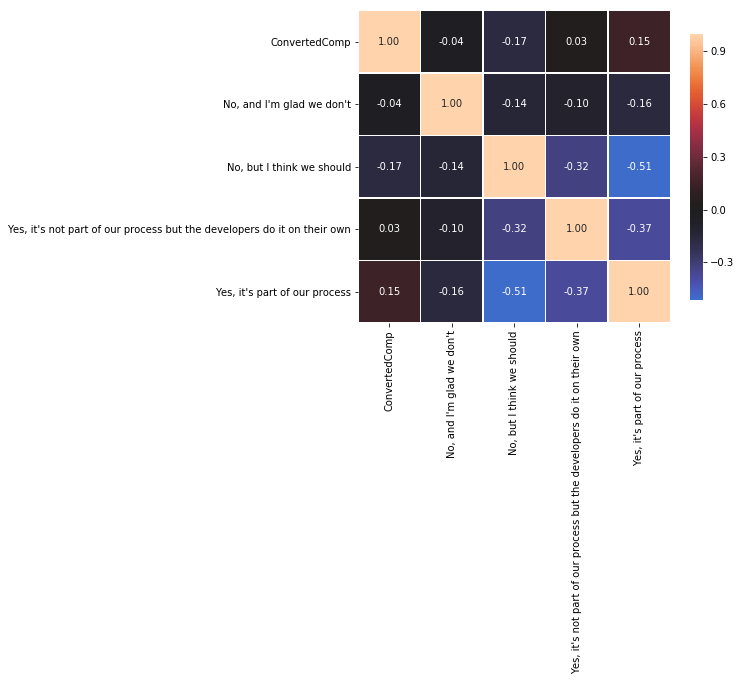

In [92]:
plot_correlation_matrix_cat(data, 'UnitTests')  

#### Variable: LastHireDate

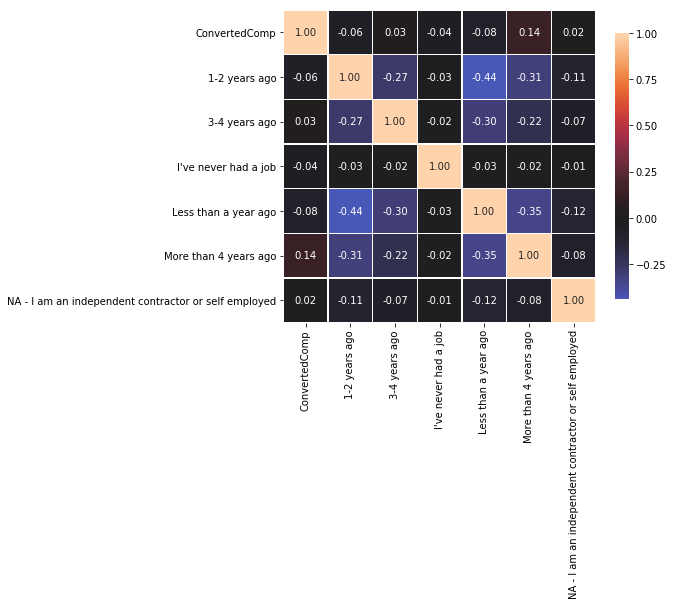

In [93]:
plot_correlation_matrix_cat(data, 'LastHireDate')

#### Variable: JobSeek

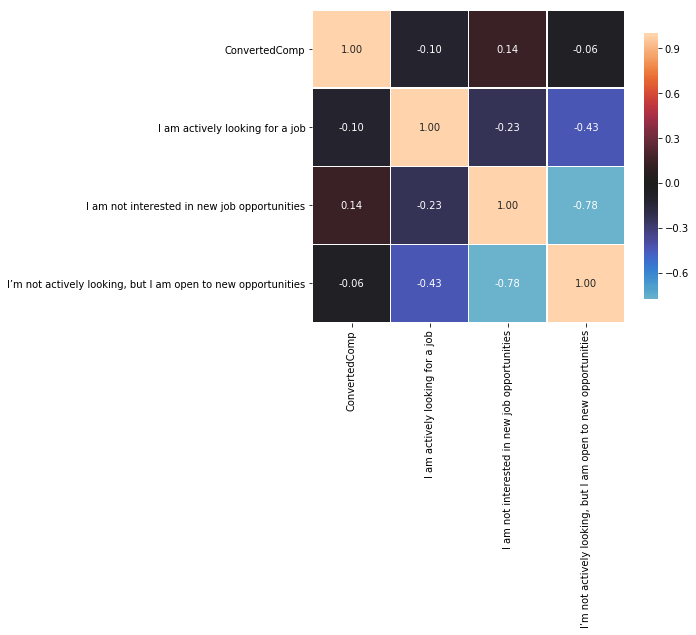

In [94]:
plot_correlation_matrix_cat(data, 'JobSeek')  

We have confirmed all columns that were preselected except Gender column. Let us stress that since we haven't executed any t-tests all our conclusion about the feature significance is based on the *practical statistic*.

## Sanitizing Data

In [123]:
cols = list(variables.column)
cols.append(label)
target = data[cols].copy()
target.shape

(46394, 18)

### Missing Values

In [124]:
missing_stat(target)

               count  percentage
UnitTests       4079        8.79
Age             1847        3.98
OrgSize          842        1.81
EdLevel          711        1.53
FizzBuzz         378        0.81
Student          281        0.61
YearsCodePro     130        0.28
WorkRemote       121        0.26
Employment       114        0.25
ImpSyn           102        0.22
CodeRev           95        0.20
YearsCode         68        0.15
JobSat            51        0.11
LastHireDate      46        0.10
JobSeek            0        0.00
Country            0        0.00
CareerSat          0        0.00
ConvertedComp      0        0.00
-------------------------------------------------
Total missing rows: 16.37%
-------------------------------------------------


The percentage of total missing rows is not very high. We opt for removing the rows with the missing values.

In [125]:
# Drop rows with at least one missing value
target = target.dropna(how='any', axis=0)
target.shape

(38799, 18)

In [126]:
missing_stat(target)

               count  percentage
Employment         0         0.0
Country            0         0.0
Age                0         0.0
UnitTests          0         0.0
CodeRev            0         0.0
ImpSyn             0         0.0
WorkRemote         0         0.0
FizzBuzz           0         0.0
LastHireDate       0         0.0
JobSeek            0         0.0
JobSat             0         0.0
CareerSat          0         0.0
YearsCodePro       0         0.0
YearsCode          0         0.0
OrgSize            0         0.0
EdLevel            0         0.0
Student            0         0.0
ConvertedComp      0         0.0
-------------------------------------------------
Total missing rows: 0.0%
-------------------------------------------------


### Data Adjustments

#### Student

In [127]:
unique(target, 'Student')

No                33017
Yes, full-time     3416
Yes, part-time     2366
Name: Student, dtype: int64

Since the Student feature is based on Yes/No question, we'll convert 'Yes, full-time' and 'Yes, part-time' into 'Yes'. the information 'full-time', 'part-time' is not important.

In [128]:
def get_student(val):
    '''
    Sanitize Student values.
    
    INPUT
    val - value to sanitize
    
    OUTPUT
    'Yes', 'No', or 'not found'
    '''             
    if val in ['Yes, full-time', 'Yes, part-time']:
        return 'Yes'
    elif val in ['No', 'N/A']:
        return val
    else:
        return 'not found'
    
    
target.Student = target.Student.apply(get_student)
unique(target, 'Student')

No     33017
Yes     5782
Name: Student, dtype: int64

In [129]:
def find_non_numeric(data, col):
    '''
    Find non-numeric data.
    
    INPUT
    data - pandas dataframe
    col - column with data
    
    OUTPUT
    non-numeric data or '*** All values are numeric. ***'
    '''              
    found = False
    for val in unique(data, col).index:
        try:
            int(val)
        except:
            found = True
            print(val)
            
    if found == False:
        print('*** All values are numeric. ***')
        

In [130]:
find_non_numeric(target, 'YearsCodePro')
find_non_numeric(target, 'YearsCode')

*** All values are numeric. ***
*** All values are numeric. ***


### X, y

In [139]:
X = target.drop(label, axis=1).copy()
y = target[label].copy()

In [140]:
print(X.shape)
print(y.shape)

(38799, 17)
(38799,)


### Encoding

We'll one-hot-encode categorical values and prepare model data sets.

In [142]:
for var in variables[variables.dtype == 'string'].column:
    X = pd.concat([X.drop(var, axis=1), 
                   pd.get_dummies(X[var], 
                                prefix=var, 
                                prefix_sep='_', 
                                drop_first=True)], axis=1) 
    
X.head()

,YearsCode,YearsCodePro,Age,Employment_Employed part-time,Country_Australia,Country_Austria,Country_Bangladesh,Country_Belgium,Country_Brazil,Country_Bulgaria,...,"WorkRemote_More than half, but not all, the time",ImpSyn_A little below average,ImpSyn_Average,ImpSyn_Far above average,ImpSyn_Far below average,"CodeRev_Yes, because I see value in code review","CodeRev_Yes, because I was told to do so","UnitTests_No, but I think we should","UnitTests_Yes, it's not part of our process but the developers do it on their own","UnitTests_Yes, it's part of our process"
3,3.0,0.0,22.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
8,12.0,4.0,23.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
12,17.0,8.0,28.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
13,13.0,2.0,31.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
16,5.0,2.0,29.0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [143]:
X.columns.tolist()

['YearsCode',
 'YearsCodePro',
 'Age',
 'Employment_Employed part-time',
 'Country_Australia',
 'Country_Austria',
 'Country_Bangladesh',
 'Country_Belgium',
 'Country_Brazil',
 'Country_Bulgaria',
 'Country_Canada',
 'Country_China',
 'Country_Colombia',
 'Country_Croatia',
 'Country_Czech Republic',
 'Country_Denmark',
 'Country_Egypt',
 'Country_Finland',
 'Country_France',
 'Country_Germany',
 'Country_Greece',
 'Country_Hungary',
 'Country_India',
 'Country_Indonesia',
 'Country_Iran',
 'Country_Ireland',
 'Country_Israel',
 'Country_Italy',
 'Country_Japan',
 'Country_Lithuania',
 'Country_Mexico',
 'Country_Netherlands',
 'Country_New Zealand',
 'Country_Nigeria',
 'Country_Norway',
 'Country_Pakistan',
 'Country_Philippines',
 'Country_Poland',
 'Country_Portugal',
 'Country_Romania',
 'Country_Russian Federation',
 'Country_Serbia',
 'Country_Slovakia',
 'Country_Slovenia',
 'Country_South Africa',
 'Country_Spain',
 'Country_Sri Lanka',
 'Country_Sweden',
 'Country_Switzerlan

In [144]:
X.shape

(38799, 100)

In [44]:
# Udacity code:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.figure(figsize = (10,5))
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

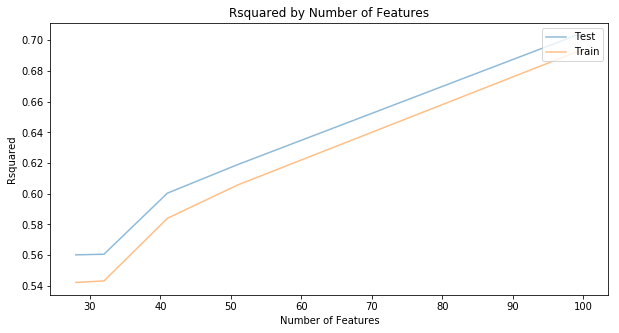

In [145]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [146]:
r2_scores_train

[0.54223340338558268,
 0.54322198070857408,
 0.58401394396515083,
 0.60577050564486457,
 0.69230140986740241,
 0.69231834910048917,
 0.69231834910048917,
 0.69231834910048917]

In [147]:
r2_scores_test

[0.56020640698449498,
 0.56062277456142939,
 0.60041177843922211,
 0.61905099455660761,
 0.70319182407921699,
 0.70320319170833101,
 0.70320319170833101,
 0.70320319170833101]

In [148]:
# Udacity code:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(50)

,est_int,coefs,abs_coefs
52,Country_United States,66913.433657,66913.433657
48,Country_Switzerland,62535.560731,62535.560731
26,Country_Israel,59514.099057,59514.099057
15,Country_Denmark,53725.695186,53725.695186
34,Country_Norway,48262.270746,48262.270746
4,Country_Australia,46421.980814,46421.980814
25,Country_Ireland,40992.147118,40992.147118
10,Country_Canada,39639.013569,39639.013569
19,Country_Germany,34857.557019,34857.557019
32,Country_New Zealand,33810.618407,33810.618407


## Conclusion

With 100 features we have reached around 0.7 of R2 which means that our goal has been achieved. We see that the both curves are still parallel, no point of separation appears which means that there is still some margin of adding more features. 

REMARK:
*We have also tried some other feature configuration (not published here). We tested with 15 countries and very limited number of features (up to 40) and reached 0.6 of R2. It turned out that it is important to cut off the outliers and limit the salary to 170.000 USD which gave us the best ratio between the number of features and R2.* 